In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("/Users/hintont/Dev/packages")
import os
import csi.insar as ir
import csi.TriangularPatches as triangleFault
import csi.imagedownsampling as imdown
import csi.imagecovariance as imcov
import csi.multifaultsolve as multiflt
import csi.transformation as transformation
import csi.gps as gr
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pickle



####    CONFIG    ####
main_dir = "/Users/hintont/Dev/projects/Ridgecrest"
insar_dir = os.path.join(main_dir, "data/insar")

utm_zone = "11"
lon0 = 360 - 117.5
lat0 = 35.7

In [3]:
####    FAULTS    ####
fault_dir = os.path.join(main_dir, "data/fault")
fault_filenames = ["fault1.mesh.triangles", "fault3.mesh.triangles"]

faults = []
for i, filename in enumerate(fault_filenames):

    fault = triangleFault(f"fault{i}", utmzone=utm_zone, lon0=lon0, lat0=lat0)
    fault.readGocadPatches( os.path.join(fault_dir, filename) )
    
    fault.setTrace(delta_depth=0.2)

    faults.append(fault)

---------------------------------
---------------------------------
Initializing fault fault0
---------------------------------
---------------------------------
Initializing fault fault1


In [ ]:
####    INSAR DATA    ####
insar_names = ["A064_20190704-0710", "D071_20190704-0716"]
insars = []

for insar_name in insar_names:


    ####    LOAD INSAR DATA    ####
    insar_subdir = os.path.join(insar_dir, insar_name)

    MINLON, MAXLON, MINLAT, MAXLAT = 360-118.1, 360-117.0 ,35.3, 36.2

    unw = os.path.join(insar_subdir, "unwrapped.grd")
    e = os.path.join(insar_subdir, "east.grd")
    n = os.path.join(insar_subdir, "north.grd")
    u = os.path.join(insar_subdir, "up.grd")

    sar = ir(insar_name, utmzone=utm_zone, lon0=lon0, lat0=lat0)
    sar.read_from_grd( unw, los=[ e, n, u ], factor=1.)

    sar.select_pixels(MINLON, MAXLON, MINLAT, MAXLAT)
    sar.checkNaNs()



    ####    COMPUTE COVARIANCE    ####
    covar = imcov(insar_name, sar, verbose=True)

    covar.selectedZones = []
    covar.maskOut([ 360-117.88,360-117.3,35.53,35.9])

    covar.computeCovariance(function='exp', frac=0.005, every=0.5, distmax=35.,tol=1e-10)

    sigma, lamda = covar.datasets[insar_name]["Sigma"], covar.datasets[insar_name]["Lambda"]
    print("SAR covariance", (sigma, lamda))



    ####    DISTANCE-BASED DOWNSAMPLING    ####
    startWindowSize, minimumWindowSize, chardist, expodist, tol, reject_distance = 10., 1.25, 1.5, 0.7, 0.005, 0.5

    downsampler = imdown(insar_name, sar, faults)
    downsampler.initialstate(startWindowSize, minimumWindowSize, tolerance=tol, plot=False)
    downsampler.distanceBased(chardist=chardist, expodist=expodist)
    downsampler.reject_pixels_fault(reject_distance, faults)

    print(f"Original number of pixels: {len(sar.x)}")
    print(f"Downsampled number of pixels: {len(downsampler.newimage.x)}")

    sar = downsampler.newimage

    print("Building Cd with variable sigma and lambda:", (sigma, lamda))
    sar.buildCd(sigma, lamda, function='exp')
    insars.append(sar)

In [ ]:
datasets = insars

####   BUILD GREENS FUNCTIONS    ####
for fault in faults:
    fault.initializeslip()
    for dataset in datasets:
        fault.buildGFs(dataset, slipdir="sd")
    fault.assembleGFs(datasets, slipdir="sd", polys=None)
    fault.assembled(datasets)
    fault.assembleCd(datasets)

In [5]:
####    GNSS DATA    ####
gnss_dir = os.path.join(main_dir, "data/gnss")
gnss_names = ["unr_gps_offsets_full.txt"]
gnsss = []

for gnss_name in gnss_names:
    gnss = gr(gnss_name, utmzone=utm_zone, lon0=lon0, lat0=lat0)
    gnss.read_from_enu(os.path.join(gnss_dir, gnss_name), header=2, checkNaNs=False)
    gnss.reject_stations_awayfault(100, faults)
    gnss.buildCd(direction='enu')
    gnss.Cd *= 4.
    gnsss.append(gnss)

---------------------------------
---------------------------------
Initialize GPS array unr_gps_offsets_full.txt
Read data from file /Users/hintont/Dev/projects/Ridgecrest/data/gnss/unr_gps_offsets_full.txt into data set unr_gps_offsets_full.txt


In [ ]:
import pickle
with open(os.path.join(main_dir, "results/in01/inputs/tmp.pkl"), "wb") as f:
    pickle.dump((datasets, faults), f)

In [21]:
datasets, faults = pickle.load(open(os.path.join(main_dir, "results/in01/inputs/tmp.pkl"), "rb"))

In [ ]:
faults[0].plot(view=(20., 45.), norm=(0., 2.))
faults[1].plot(view=(20., 180.), norm=(0., 2.))

In [ ]:
faults[0].patch[0]

(0.0, 360.0)

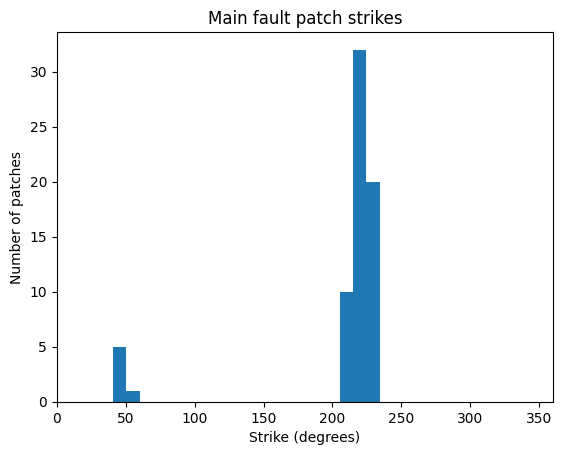

In [13]:
strikes = []
for i in range(len(faults[1].patch)):
    strikes.append(faults[1].getpatchgeometry(i)[5])
strikes = np.array(strikes)
strikes = np.degrees(strikes)
plt.hist(strikes, bins=20)
plt.title("Main fault patch strikes")
plt.xlabel("Strike (degrees)")
plt.ylabel("Number of patches")
plt.xlim(0, 360)

In [ ]:
m = 0.125 / 0.14
c = 35.575 + 117.6 * 0.125 / 0.14
for dataset in datasets:
    u = np.where(dataset.lat < (m * dataset.lon + c))[0]
    print(f"{dataset.name}: {len(u)} pixels below line, {len(dataset.lon) - len(u)} pixels above line")
    dataset.keepPixels(u)

####   REBUILD GREENS FUNCTIONS    ####
for fault in faults:
    fault.initializeslip()
    for dataset in datasets:
        fault.buildGFs(dataset, slipdir="sd")
    fault.assembleGFs(datasets, slipdir="sd", polys=None)
    fault.assembled(datasets)
    fault.assembleCd(datasets)

Greens functions computation method: Meade
---------------------------------
---------------------------------
Building Green's functions for the data set 
Downsampled A064_20190704-0710 of type insar in a homogeneous half-space
 Patch: 253 / 253  
Greens functions computation method: Meade
---------------------------------
---------------------------------
Building Green's functions for the data set 
Downsampled D071_20190704-0716 of type insar in a homogeneous half-space
 Patch: 253 / 253  
---------------------------------
---------------------------------
Assembling G for fault fault0
Dealing with Downsampled A064_20190704-0710 of type insar
Dealing with Downsampled D071_20190704-0716 of type insar
---------------------------------
---------------------------------
Assembling d vector
Dealing with data Downsampled A064_20190704-0710
Dealing with data Downsampled D071_20190704-0716
Greens functions computation method: Meade
---------------------------------
-------------------------

In [ ]:
Gs = faults[1].G["Downsampled A064_20190704-0710"]["strikeslip"]
plt.hist(Gs.flatten(), bins=50)

array([[ 2.57565139e-04,  7.40574151e-05,  8.27747738e-05, ...,
         5.88619742e-05,  9.23483625e-05,  1.50691940e-04],
       [ 4.45144508e-04,  1.51964323e-04,  1.52649769e-04, ...,
         1.23737148e-04,  1.77990952e-04,  2.64695428e-04],
       [ 4.04057377e-04,  1.43735823e-04,  1.48417917e-04, ...,
         1.43572679e-04,  2.26559477e-04,  3.63757407e-04],
       ...,
       [-2.39904057e-04, -3.26189853e-04, -2.75786222e-04, ...,
        -8.89781343e-05, -9.97957582e-05, -1.08313072e-04],
       [-1.69804504e-04, -2.24195349e-04, -1.81351980e-04, ...,
        -6.23112192e-05, -6.73768856e-05, -6.90138362e-05],
       [-1.34895015e-04, -1.33419034e-04, -1.06196748e-04, ...,
        -4.10795819e-05, -4.46610366e-05, -4.67011323e-05]],
      shape=(295, 68))

Cannot plot ellipses or quiverkey if scale is None


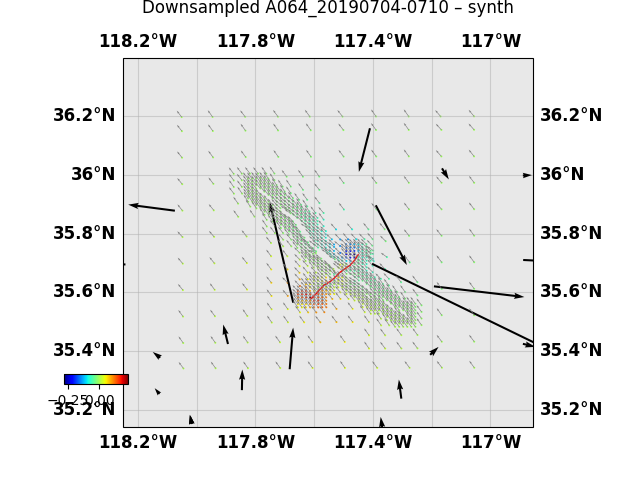

Cannot plot ellipses or quiverkey if scale is None


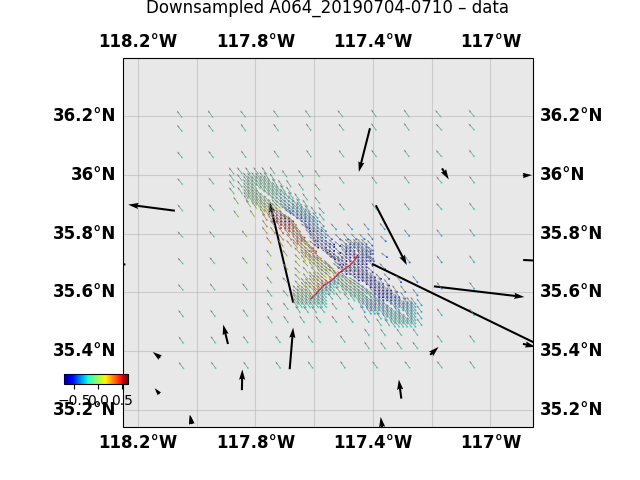

Cannot plot ellipses or quiverkey if scale is None


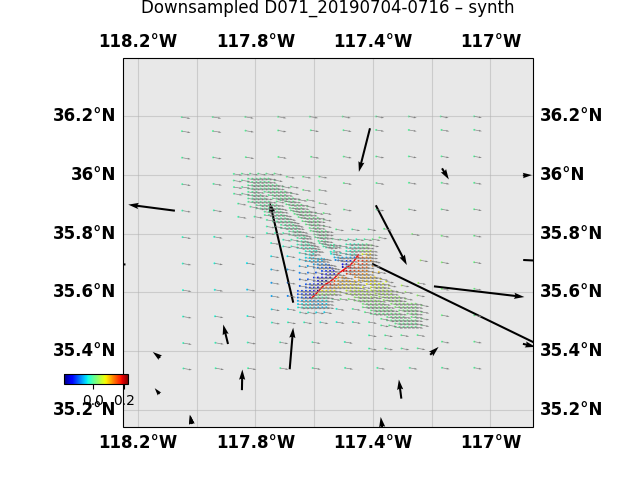

Cannot plot ellipses or quiverkey if scale is None


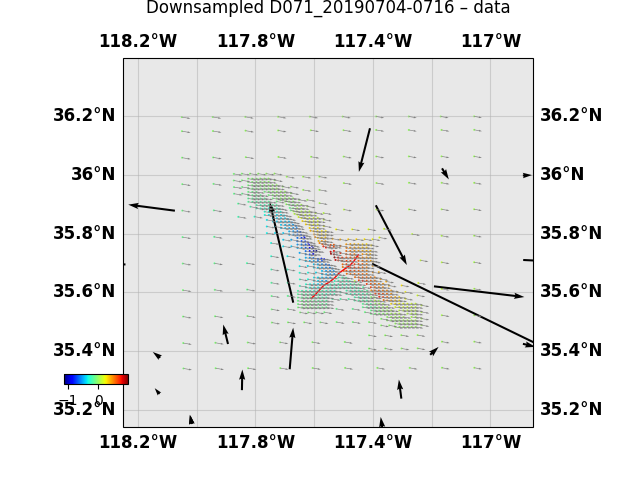

In [24]:
%matplotlib ipympl
plt.close("all")
for fault in faults:
    fault.slip[:,0] = 0.

fault = faults[1]
fault.slip[:,0] = 1.

for data in datasets:
    data.buildsynth(faults)
    args = {}
    args = {"los": [data.lon, data.lat, data.los[:,0], data.los[:,1], {"color":'grey', "width":0.0015}], "gps": gnsss}
    data.plot(title=f"{data.name} – synth", data="synth", markersize=2., faults=[fault], **args)
    data.plot(title=f"{data.name} – data", data="data", markersize=2., faults=[fault], **args)

In [ ]:
data.fig.carte.quiver(data.lon, data.lat, data.los[:,0], data.los[:,1], color='k', zorder=12)
data.fig.show()